In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
os.getcwd()

NameError: name 'os' is not defined

In [4]:
import os
dfs_our = []
for entry in os.scandir('../data/encoded'):
    group_df = pd.read_csv(entry.path)
    dfs_our.append(group_df)
df_our = pd.concat(dfs_our)

print(df_our.shape)
df_our.head()

(2654, 63)


,ID,Время создания,Время изменения,Ваш пол,Сколько вам лет?,"Укажите тип населённого пункта, в котором вы проживаете.",Источник ответов,Кого бы вы НЕ хотели видеть своим соседом? / Наркозависимого,Кого бы вы НЕ хотели видеть своим соседом? / Человека другой расы,Кого бы вы НЕ хотели видеть своим соседом? / Гомосексуала,...,Q130: Immigration policy preference,Q189: Justifiable: For a man to beat his wife,Q182: Justifiable: Homosexuality,Q183: Justifiable: Prostitution,Q184: Justifiable: Abortion,Q190: Justifiable: Parents beating children,Q186: Justifiable: Sex before marriage,Q187: Justifiable: Suicide,Q188: Justifiable: Euthanasia,Q193: Justifiable: Having casual sex
0,1090643861,2022-02-09 21:37:05,2022-02-09 21:37:05,Женский,более 50,средний город (50-100 тыс. жителей),female_50,NaN,NaN,NaN,...,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0
1,1090637564,2022-02-09 21:30:53,2022-02-09 21:30:53,Женский,более 50,средний город (50-100 тыс. жителей),female_50,Наркозависимого,NaN,NaN,...,3,1.0,1.0,1.0,5.0,1.0,10.0,1.0,5.0,5.0
2,1090636590,2022-02-09 21:29:54,2022-02-09 21:29:54,Женский,более 50,крупный город (свыше 500 тыс. жителей),female_50,Наркозависимого,NaN,NaN,...,3,1.0,1.0,1.0,5.0,5.0,5.0,1.0,1.0,3.0
3,1090635914,2022-02-09 21:29:15,2022-02-09 21:29:15,Женский,более 50,посёлок городского типа,female_50,Наркозависимого,NaN,NaN,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1090634270,2022-02-09 21:27:28,2022-02-09 21:27:28,Женский,более 50,средний город (50-100 тыс. жителей),female_50,Наркозависимого,NaN,Гомосексуала,...,3,1.0,1.0,1.0,7.0,3.0,10.0,1.0,3.0,2.0


In [5]:
df_our=df_our[df_our['failed_control'] == False]
df_our

,ID,Время создания,Время изменения,Ваш пол,Сколько вам лет?,"Укажите тип населённого пункта, в котором вы проживаете.",Источник ответов,Кого бы вы НЕ хотели видеть своим соседом? / Наркозависимого,Кого бы вы НЕ хотели видеть своим соседом? / Человека другой расы,Кого бы вы НЕ хотели видеть своим соседом? / Гомосексуала,...,Q130: Immigration policy preference,Q189: Justifiable: For a man to beat his wife,Q182: Justifiable: Homosexuality,Q183: Justifiable: Prostitution,Q184: Justifiable: Abortion,Q190: Justifiable: Parents beating children,Q186: Justifiable: Sex before marriage,Q187: Justifiable: Suicide,Q188: Justifiable: Euthanasia,Q193: Justifiable: Having casual sex
0,1090643861,2022-02-09 21:37:05,2022-02-09 21:37:05,Женский,более 50,средний город (50-100 тыс. жителей),female_50,NaN,NaN,NaN,...,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0
2,1090636590,2022-02-09 21:29:54,2022-02-09 21:29:54,Женский,более 50,крупный город (свыше 500 тыс. жителей),female_50,Наркозависимого,NaN,NaN,...,3,1.0,1.0,1.0,5.0,5.0,5.0,1.0,1.0,3.0
7,1090632694,2022-02-09 21:25:52,2022-02-09 21:25:52,Женский,более 50,крупный город (свыше 500 тыс. жителей),female_50,Наркозависимого,NaN,NaN,...,3,1.0,3.0,8.0,9.0,1.0,6.0,8.0,8.0,8.0
9,1090631809,2022-02-09 21:25:00,2022-02-09 21:25:00,Женский,более 50,крупный город (свыше 500 тыс. жителей),female_50,Наркозависимого,NaN,NaN,...,-1,1.0,5.0,1.0,5.0,2.0,6.0,8.0,6.0,6.0
10,1090631142,2022-02-09 21:24:18,2022-02-09 21:24:18,Женский,более 50,малый город (до 50 тыс. жителей),female_50,NaN,NaN,NaN,...,3,1.0,1.0,5.0,5.0,3.0,3.0,3.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,1020765555,2021-12-15 13:34:35,2021-12-15 13:34:35,Мужской,до 29,средний город (50-100 тыс. жителей),male_29,Наркозависимого,NaN,Гомосексуала,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
287,1020765493,2021-12-15 13:34:33,2021-12-15 13:34:33,Мужской,до 29,средний город (50-100 тыс. жителей),male_29,Наркозависимого,NaN,Гомосексуала,...,3,1.0,3.0,1.0,5.0,1.0,10.0,1.0,1.0,7.0
288,1020765079,2021-12-15 13:34:16,2021-12-15 13:34:16,Мужской,до 29,крупный город (свыше 500 тыс. жителей),male_29,Наркозависимого,NaN,Гомосексуала,...,3,1.0,3.0,5.0,10.0,2.0,9.0,1.0,10.0,6.0
290,1020763178,2021-12-15 13:33:01,2021-12-15 13:33:01,Мужской,30-49,крупный город (свыше 500 тыс. жителей),male_29,Наркозависимого,NaN,NaN,...,3,1.0,10.0,10.0,10.0,1.0,10.0,10.0,10.0,10.0


In [6]:
#df_test = pd.read_excel('C:\\Users\\Andrew/data/world_values_survey.xlsx')
df_test = pd.read_excel('../data/world_values_survey_extended.xlsx')
df_test = df_test[df_test.columns[1:]] # Remove unnamed column
df_test

,Q18: Neighbors: Drug addicts,Q19: Neighbors: People of a different race,Q22: Neighbors: Homosexuals,Q21: Neighbors: Immigrants/foreign workers,Q23: Neighbors: People of a different religion,Q29: Men make better political leaders than women do,Q36: Homosexual couples are as good parents as other couples,Q212: Political action: Joining unofficial strikes,Q71: Confidence: The Government,Q69: Confidence: The Police,...,Q183: Justifiable: Prostitution,Q184: Justifiable: Abortion,Q190: Justifiable: Parents beating children,Q186: Justifiable: Sex before marriage,Q187: Justifiable: Suicide,Q188: Justifiable: Euthanasia,Q193: Justifiable: Having casual sex,Q223: Which party would you vote for if there were a national election tomorrow,Q260: Sex,Q262: Age
0,1,2,1,2,2,3,4,3,2,3,...,1,8,1,8,1,1,9,643032,2,36
1,1,2,2,2,1,3,4,3,3,2,...,6,6,1,9,1,3,4,643003,2,58
2,1,2,2,2,2,3,3,3,3,2,...,7,5,4,9,4,3,9,643032,1,42
3,1,2,2,1,2,2,3,3,2,2,...,1,3,5,3,1,-1,6,643032,2,47
4,1,2,2,2,2,3,4,3,2,2,...,3,10,4,10,8,10,7,643037,2,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805,1,2,2,2,2,2,4,1,1,3,...,1,1,3,-1,1,1,-1,643032,1,67
1806,1,2,2,2,2,1,5,3,2,4,...,1,1,1,8,2,-1,1,643034,1,74
1807,1,2,2,2,2,-1,5,3,3,2,...,1,10,1,7,1,-1,-1,643032,1,55
1808,1,2,2,2,2,2,3,3,2,3,...,1,1,3,-1,1,1,-1,643032,2,30


In [180]:
df_our['source'] = 'ours'
df_test['source'] = 'world_values_survey'
df = pd.concat([df_our, df_test])
df_our.shape, df_test.shape, df.shape

((1957, 64), (1810, 26), (3767, 67))

In [181]:
df.head().T

,0,2,7,9,10
ID,1090643861.0,1090636590.0,1090632694.0,1090631809.0,1090631142.0
Время создания,2022-02-09 21:37:05,2022-02-09 21:29:54,2022-02-09 21:25:52,2022-02-09 21:25:00,2022-02-09 21:24:18
Время изменения,2022-02-09 21:37:05,2022-02-09 21:29:54,2022-02-09 21:25:52,2022-02-09 21:25:00,2022-02-09 21:24:18
Ваш пол,Женский,Женский,Женский,Женский,Женский
Сколько вам лет?,более 50,более 50,более 50,более 50,более 50
...,...,...,...,...,...
Q193: Justifiable: Having casual sex,3.0,3.0,8.0,6.0,2.0
source,ours,ours,ours,ours,ours
Q223: Which party would you vote for if there were a national election tomorrow,NaN,NaN,NaN,NaN,NaN
Q260: Sex,NaN,NaN,NaN,NaN,NaN


In [177]:
def get_age(row):
    if row.source == 'ours':
        if (row['Источник ответов'] == 'female_50') or (row['Источник ответов'] == 'male_50'):
            return '50+'
        if (row['Источник ответов'] == 'female_30_49') or (row['Источник ответов'] == 'male_30_49'):
            return '30-49'
        if (row['Источник ответов'] == 'female_29') or (row['Источник ответов'] == 'male_29'):
            return '29'
    elif row.source == 'world_values_survey':
        if row['Q262: Age'] <= 29:
            return '29'
        if row['Q262: Age'] < 49:
            return '30-49'
        return '50+'

In [185]:
def get_sex(row):
    if row.source == 'ours':
        if 'female' in row['Источник ответов']:
            return 'female'
        return 'male'
    elif row.source == 'world_values_survey':
        if row['Q260: Sex'] == 2:
            return 'female'
        return 'male'

In [188]:
df['source_age'] = df.apply(get_age, axis=1)
df['source_sex'] = df.apply(get_sex, axis=1)

In [193]:
df[['source', 'Источник ответов', 'Q262: Age', 'source_age', 'Q260: Sex', 'source_sex']].sample(5).T

,258,9,365,1442,273
source,ours,ours,ours,world_values_survey,ours
Источник ответов,female_29,female_29,male_30_49,NaN,female_50
Q262: Age,NaN,NaN,NaN,63.0,NaN
source_age,29,29,30-49,50+,50+
Q260: Sex,NaN,NaN,NaN,1.0,NaN
source_sex,female,female,male,male,female


In [228]:
from scipy.stats import ttest_ind

def plot_cats_by_category_normalized(df, col, category='source_age'):
    if category=='source_age':
        cat_values = ['29', '30-49', '50+']
    if category =='source_sex':
        cat_values = ['male', 'female']
    else:
        cat_values df[category].unqiue()
    fig, axs = plt.subplots(1, len(cat_values), figsize=(10, 7), sharey='all')
    for i, category_elem in enumerate(cat_values):
        category_df = df[df[category]==category_elem]
        sns.barplot(x=col,
                    y=col,
                    hue="source",
                    data=category_df,
                    estimator=lambda x: len(x) / len(category_df),
                    ax=axs[i],
                    )
        axs[i].set_title(f'{category} = {category_elem}')
        axs[i].get_legend().remove()
        axs[i].set(xlabel=None)

    axs[0].set(ylabel="Fraction")
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels)
    plt.suptitle(col)
    plt.show()


def plot_cats(df, col):
    plt.figure(figsize=(10,5))
    sns.countplot(x=col, hue='source', data=df)
    plt.title(col)
    plt.show()



def ttest(df, col):
    data1 = list(df[df.source=='ours'][col])
    data2 = list(df[df.source!='ours'][col])

    stat, p = ttest_ind(data1, data2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')

SyntaxError: invalid syntax (1382258884.py, line 9)

## Наркозависимый - идентично

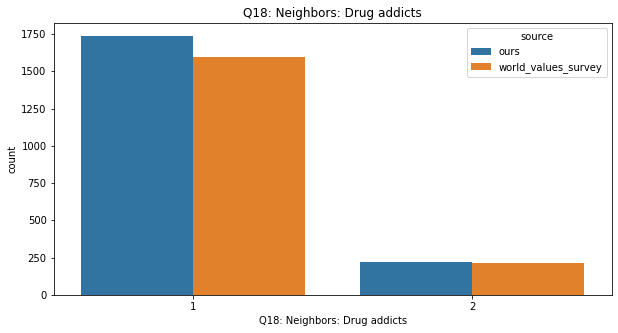

In [229]:
plot_cats(df, "Q18: Neighbors: Drug addicts")

In [230]:
ttest(df, 'Q18: Neighbors: Drug addicts')

stat=-0.558, p=0.577
Probably the same distribution


### Наркозависимые, молодёжь - идентично

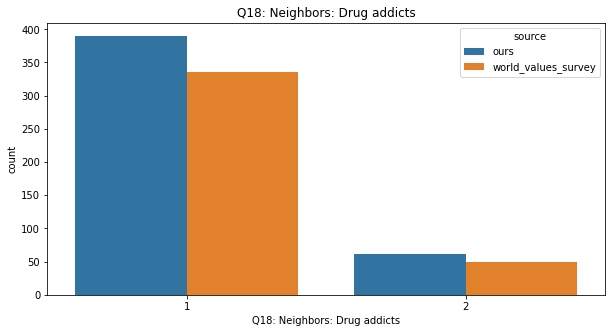

stat=0.228, p=0.819
Probably the same distribution


In [231]:
plot_cats(df[df.source_age == '29'], "Q18: Neighbors: Drug addicts")
ttest(df[df.source_age == '29'], "Q18: Neighbors: Drug addicts")

## Наркозависимые, средний возраст ХУЖЕ относится к наркозависимым???

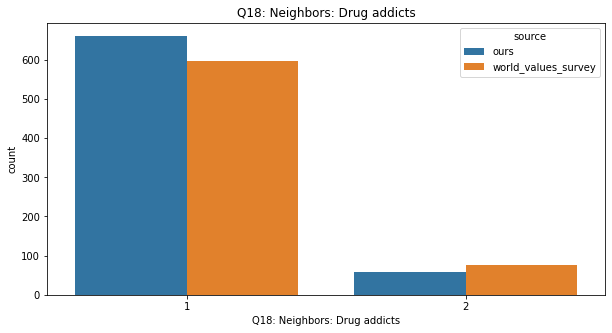

stat=-2.042, p=0.041
Probably different distributions


In [232]:
plot_cats(df[df.source_age == '30-49'], "Q18: Neighbors: Drug addicts")
ttest(df[df.source_age == '30-49'], "Q18: Neighbors: Drug addicts")

## Наркозависимые, старики - идентично

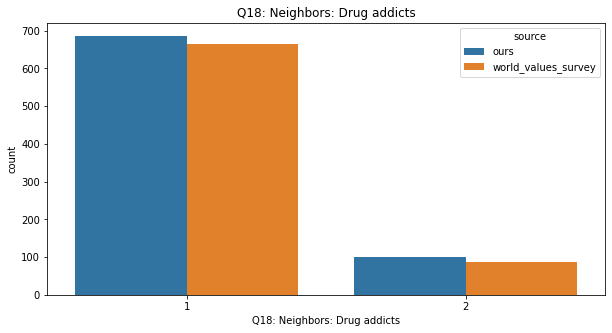

stat=0.692, p=0.489
Probably the same distribution


In [233]:
plot_cats(df[df.source_age == '50+'], "Q18: Neighbors: Drug addicts")
ttest(df[df.source_age == '50+'], "Q18: Neighbors: Drug addicts")


## Разбивка по возрасту/полу

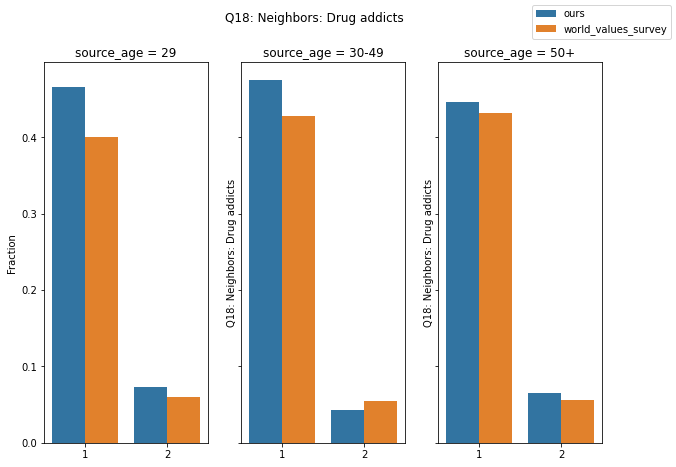

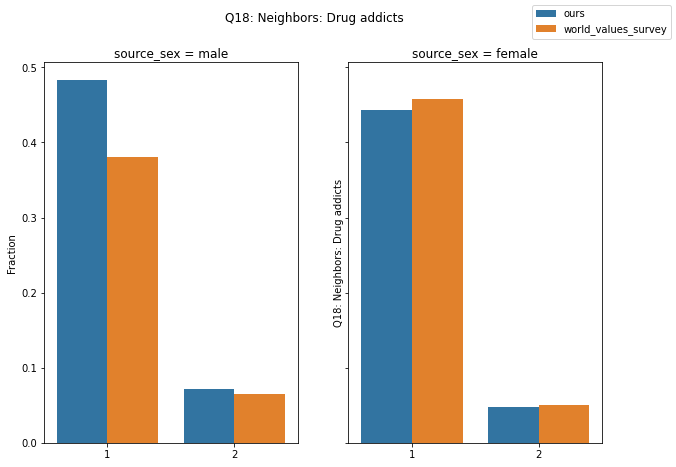

In [234]:
col = "Q18: Neighbors: Drug addicts"
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [235]:
ttest(df[df.source_sex=='male'], col)

stat=-0.916, p=0.360
Probably the same distribution


In [236]:
ttest(df[df.source_sex=='female'], col)

stat=-0.187, p=0.851
Probably the same distribution


## В интернете люди меньшие расисты 

* среди всех возрастных групп
* одинаково среди женщин и мужчин

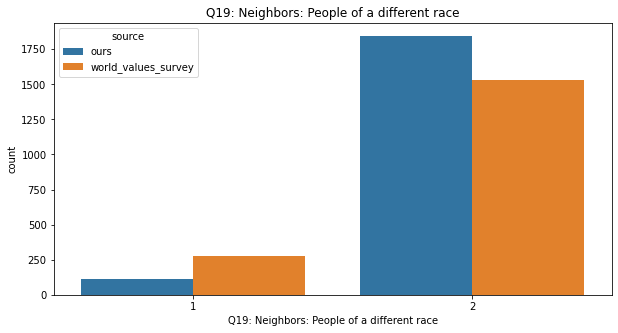

stat=9.913, p=0.000
Probably different distributions


In [237]:
col = 'Q19: Neighbors: People of a different race'
plot_cats(df, col)
ttest(df, col)

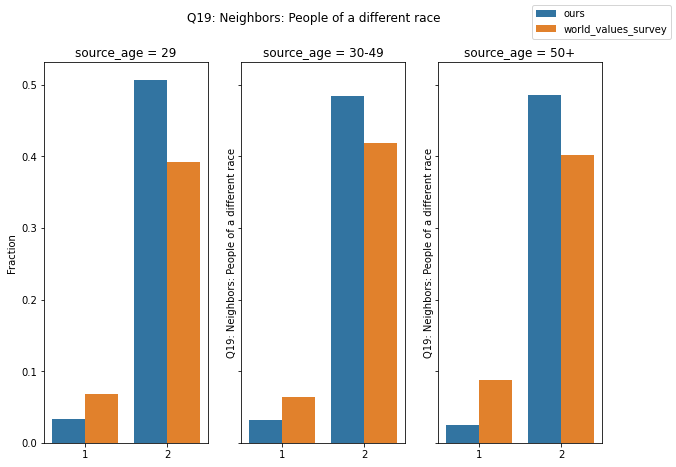

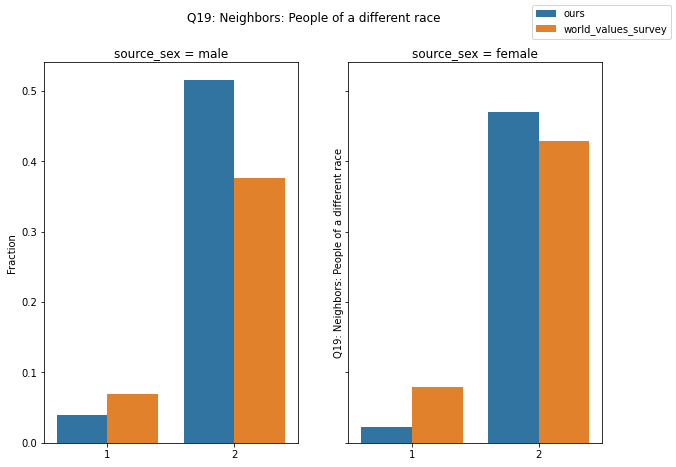

In [239]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')


## В интернете люди меньшие гомофобы
* среди всех возрастов
* одинаково среди женщин и мужчин
* в интернете женщины чуть более толерантны к гомосексуализму, чем они толерантнее в WWS

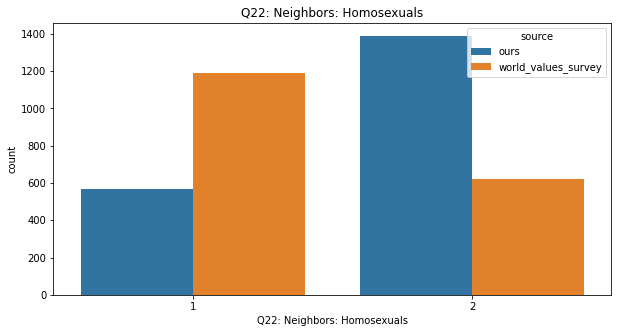

stat=24.143, p=0.000
Probably different distributions


In [240]:
col = 'Q22: Neighbors: Homosexuals'
plot_cats(df, col)
ttest(df, col)

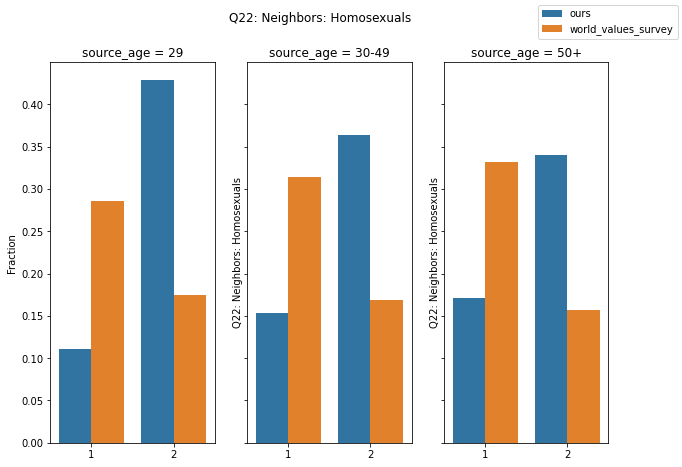

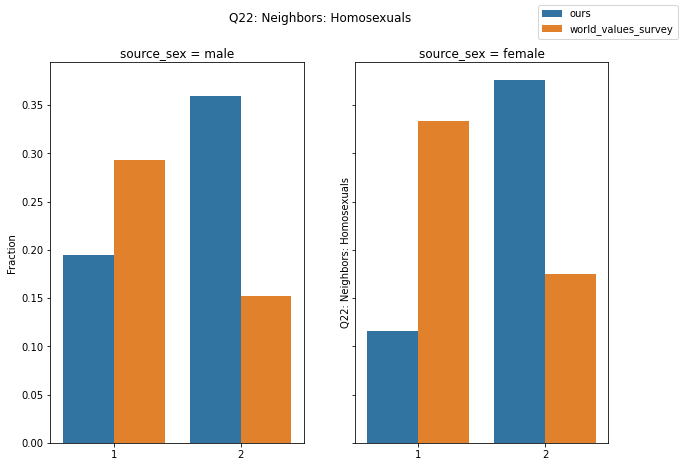

In [241]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')


## Толератнее к иммигрантам
* среди всех возрастов
* одинаково среди женщин и мужчин
* женщины в интернете чуть толерантнее

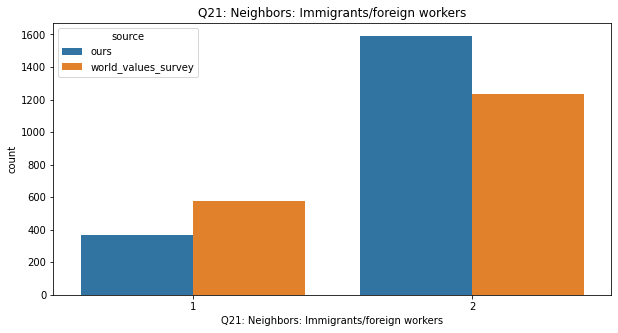

stat=9.434, p=0.000
Probably different distributions


In [244]:
col = 'Q21: Neighbors: Immigrants/foreign workers'
plot_cats(df, col)
ttest(df, col)

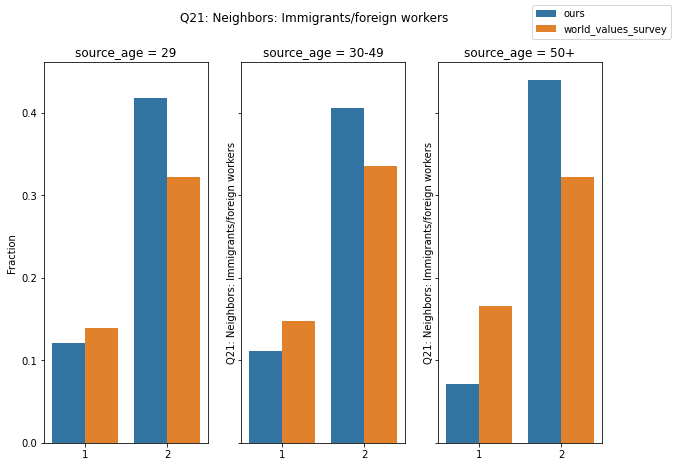

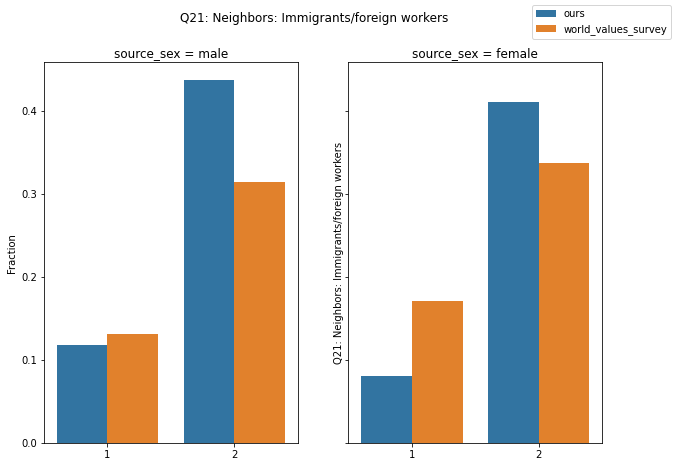

In [245]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')



## Толератнее к мусульманам

* среди всех возрастных групп, кроме молодёжи т.е. существует preference falsification среди страших возрастов ИЛИ интернет плодит исламофобию
* женщины в интернете СТАТИСТИЧЕСКИ толерантнее к иноверцам

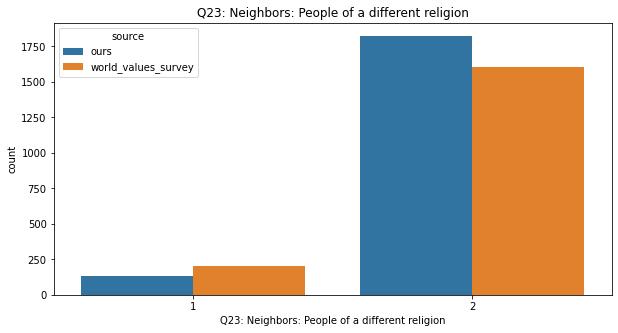

stat=4.821, p=0.000
Probably different distributions


In [246]:
col = 'Q23: Neighbors: People of a different religion'
plot_cats(df, col)
ttest(df, col)

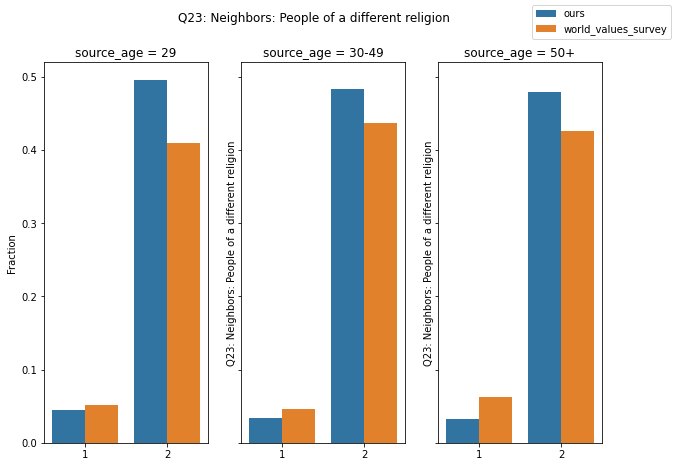

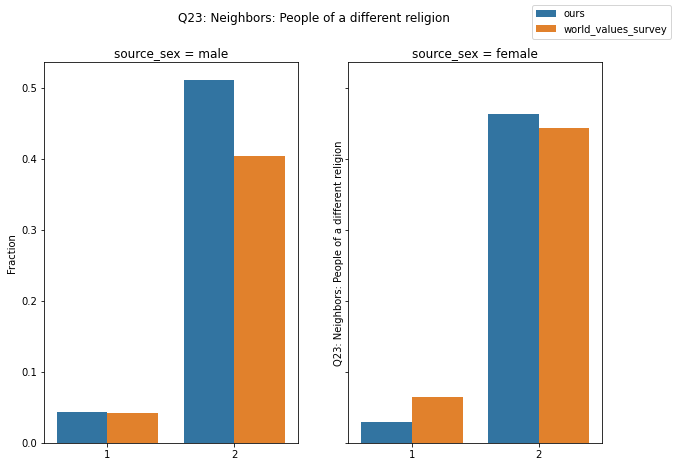

In [247]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [248]:
ttest(df[df.source_sex=='male'], col)

stat=1.103, p=0.270
Probably the same distribution


In [249]:
ttest(df[df.source_sex=='female'], col)

stat=5.368, p=0.000
Probably different distributions


**Статистическая значимость!**

## В интернете меньше сексизма (preference falsification)

* среди пожилых людей сексизма чуть больше в интернете (см. п. 4)
* среди молодёжи разница НЕ значима
* одинаково среди женщин и мужчин

Мужчины лучше женщин в политике

1 - полностью согласен

2 - скорее согласен

3 - скорее не согласен

4 - полностью не согласен

-1 - затрудняюсь


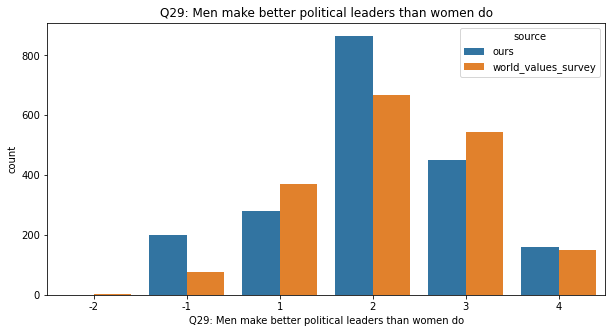

stat=-4.772, p=0.000
Probably different distributions


In [250]:
col = 'Q29: Men make better political leaders than women do'
plot_cats(df, col)
ttest(df, col)

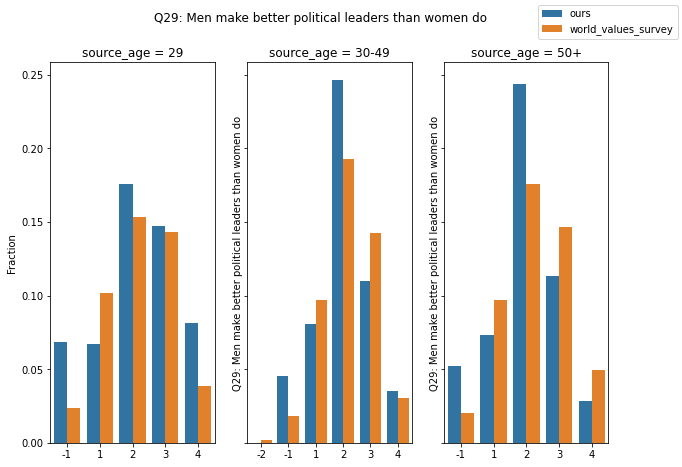

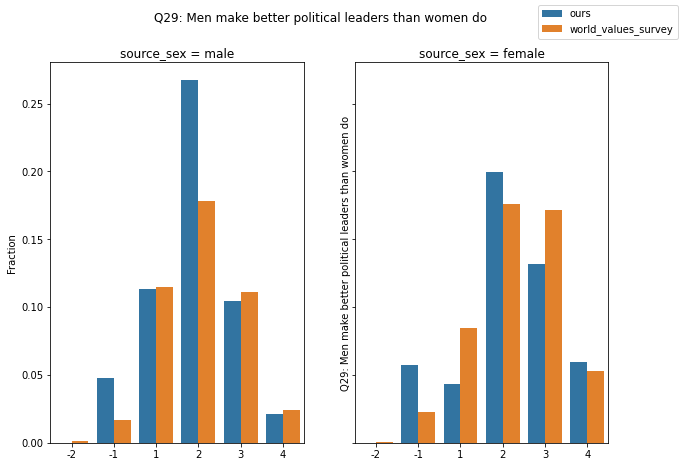

In [251]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [254]:
ttest(df[df.source_age=='29'], col)

stat=-0.329, p=0.742
Probably the same distribution


In [255]:
ttest(df[df.source_age=='30-49'], col)

stat=-2.629, p=0.009
Probably different distributions


In [256]:
ttest(df[df.source_age=='50+'], col)

stat=-4.966, p=0.000
Probably different distributions


In [252]:
ttest(df[df.source_sex=='male'], col)

stat=-3.206, p=0.001
Probably different distributions


In [253]:
ttest(df[df.source_sex=='female'], col)


stat=-3.035, p=0.002
Probably different distributions


## Столько же гомофобии
* меньше гомофобии только у МОЛОДЁЖИ - preference falsification
* женщины МЕНЕЕ ГОМОФОБНЫ в интернете

Гомосексуальные пары такие же хорошие родители

1 - полностью согласен

2 - скорее согласен

3 - ни согласен, ни несогласен

4 - скорее не согласен

5 - полностью не согласен

-1 - затрудняюсь ответить

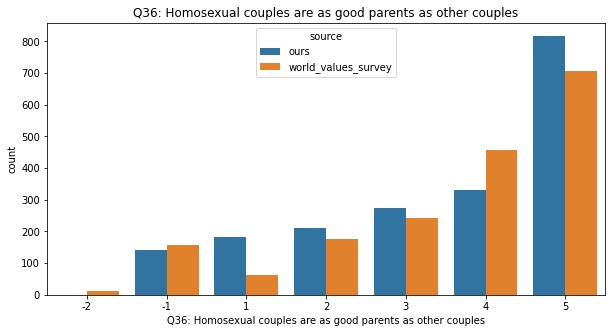

stat=-1.214, p=0.225
Probably the same distribution


In [257]:
col = 'Q36: Homosexual couples are as good parents as other couples'
plot_cats(df, col)
ttest(df, col)

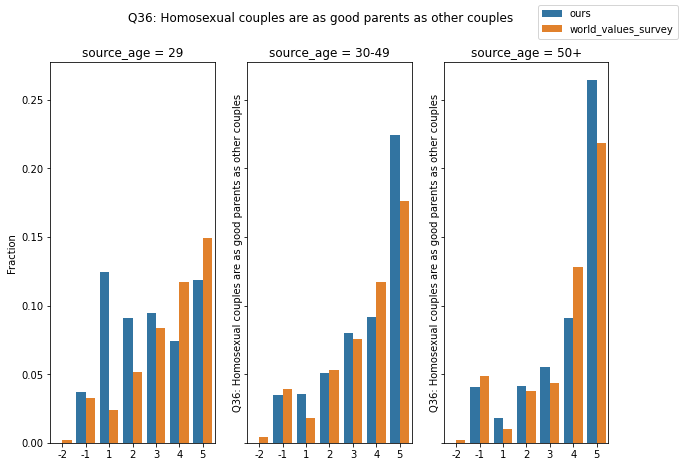

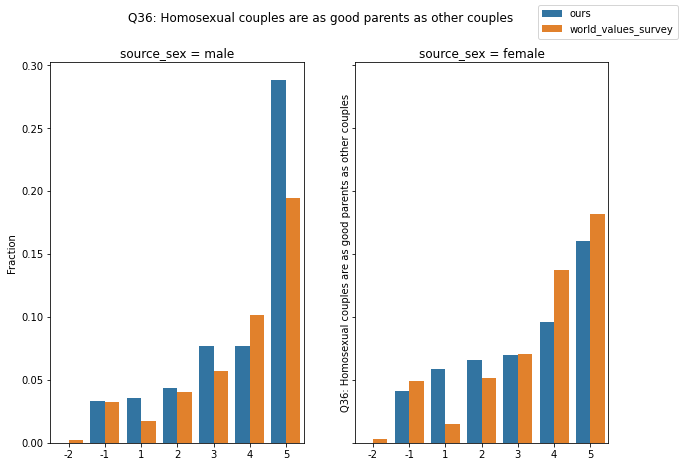

In [258]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [265]:
ttest(df[df.source_age=='29'], col)

stat=-5.858, p=0.000
Probably different distributions


In [266]:
ttest(df[df.source_age=='30-49'], col)

stat=1.313, p=0.189
Probably the same distribution


In [267]:
ttest(df[df.source_age=='50+'], col)

stat=1.292, p=0.197
Probably the same distribution


In [268]:
ttest(df[df.source_sex=='male'], col)

stat=1.327, p=0.185
Probably the same distribution


In [270]:
ttest(df[df.source_sex=='female'], col)

stat=-3.264, p=0.001
Probably different distributions


**Статистически женщины в интернете менее гомофобны**

## В Интернете чуть больше склонны к протестам

* среди всех возратсных групп
* одинаково среди женщин и мужчин

Посетили бы вы несанкицонированный митинг

1 - уже посещал

2 - мог бы посетить

3 - никогда бы не посетил

-1 - затрудняюсь ответить

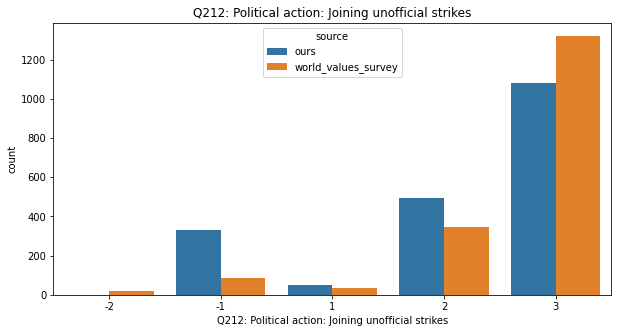

stat=-12.078, p=0.000
Probably different distributions


In [271]:
col = 'Q212: Political action: Joining unofficial strikes'
plot_cats(df, col)
ttest(df, col)

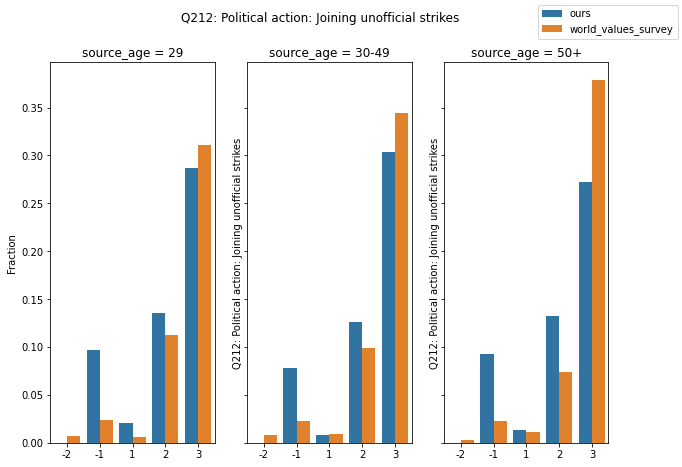

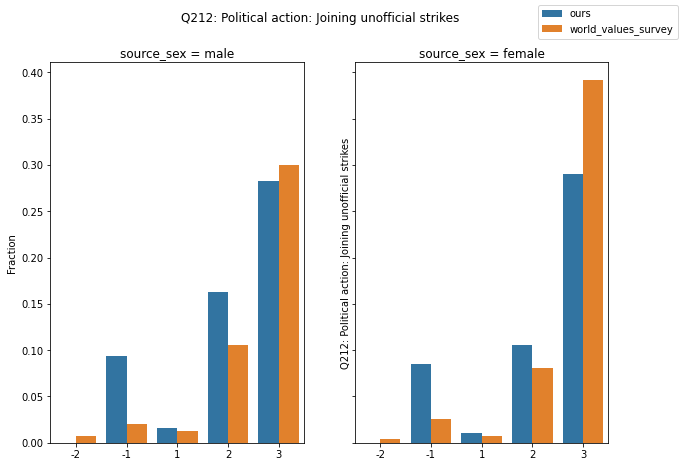

In [272]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [273]:
ttest(df[df.source_age=='29'], col)

stat=-5.339, p=0.000
Probably different distributions


In [274]:
ttest(df[df.source_age=='30-49'], col)

stat=-5.448, p=0.000
Probably different distributions


In [275]:
ttest(df[df.source_age=='50+'], col)

stat=-9.751, p=0.000
Probably different distributions


In [276]:
ttest(df[df.source_sex=='male'], col)

stat=-7.341, p=0.000
Probably different distributions


In [277]:
ttest(df[df.source_sex=='female'], col)


stat=-9.426, p=0.000
Probably different distributions


## В Интернете также не доверяют правительству

* разница статистичеси не значима по всем возрастным группам
* среди женщин и мужчин разница также статистически НЕ значима

Доверяете ли вы правительству

1 - полностью доверяю

2 - скорее доверяю

3 - скорее не доверяю

4 - полностью не доверяю

-1 - затрудняюсь ответить

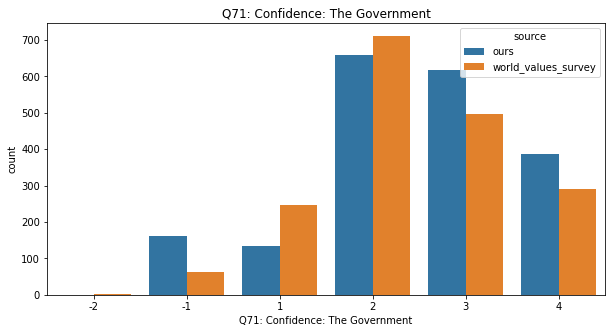

stat=1.058, p=0.290
Probably the same distribution


In [279]:
col = 'Q71: Confidence: The Government'
plot_cats(df, col)
ttest(df, col)

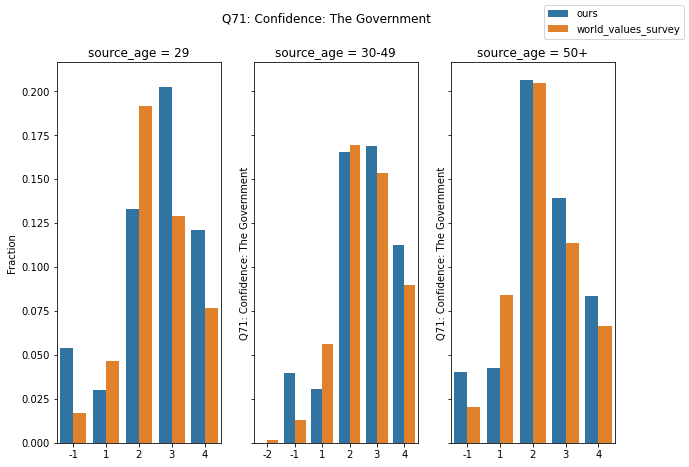

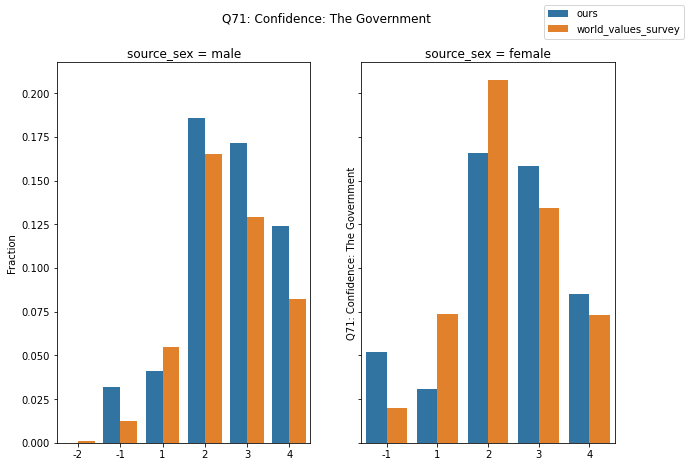

In [280]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [281]:
ttest(df[df.source_age=='29'], col)

stat=0.733, p=0.463
Probably the same distribution


In [282]:
ttest(df[df.source_age=='30-49'], col)

stat=-0.120, p=0.905
Probably the same distribution


In [283]:
ttest(df[df.source_age=='50+'], col)

stat=1.132, p=0.258
Probably the same distribution


In [284]:
ttest(df[df.source_sex=='male'], col)

stat=1.213, p=0.225
Probably the same distribution


In [285]:
ttest(df[df.source_sex=='female'], col)


stat=-0.016, p=0.987
Probably the same distribution


## В Интернете на таком же уровне не доверяют полиции

* среди всех возрастных групп
* среди женщин и мужчин


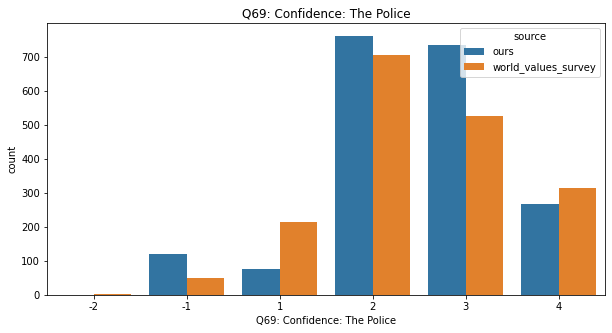

stat=-0.238, p=0.812
Probably the same distribution


In [286]:
col = 'Q69: Confidence: The Police'
plot_cats(df, col)
ttest(df, col)

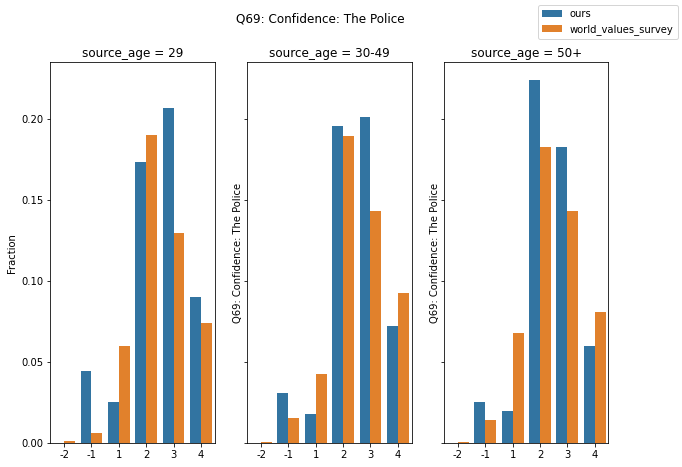

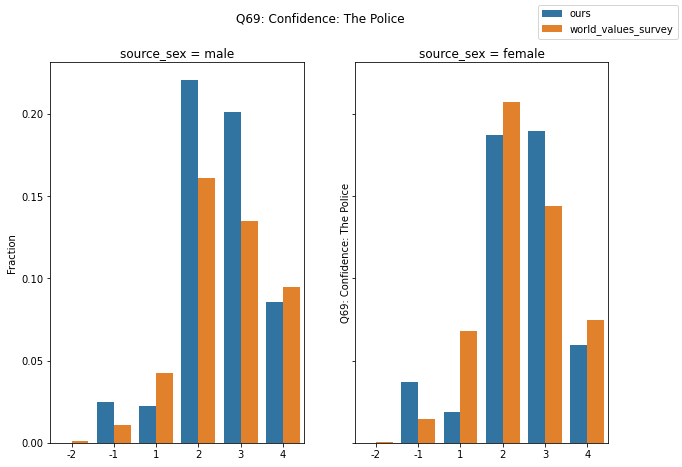

In [287]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [288]:
ttest(df[df.source_age=='29'], col)

stat=0.002, p=0.999
Probably the same distribution


In [289]:
ttest(df[df.source_age=='30-49'], col)

stat=-0.647, p=0.518
Probably the same distribution


In [290]:
ttest(df[df.source_age=='50+'], col)

stat=0.245, p=0.806
Probably the same distribution


In [291]:
ttest(df[df.source_sex=='male'], col)

stat=-1.028, p=0.304
Probably the same distribution


In [292]:
ttest(df[df.source_sex=='female'], col)



stat=0.203, p=0.839
Probably the same distribution


TypeError: plot_cats() missing 1 required positional argument: 'col'

## PREFERENCE FALSIFICATION (!!!) - БОЛЬШЕ СЕКСИЗМА

* среди всех возрастных групп, кроме молодёжи (молодёжь не демонстрирует БОЛЬШЕ сексизма)
* среди женщин и мужчин НЕ понятно
    * вроде как ЖЕНЩИНЫ больше ДОВЕРЯЮТ
    * мужчины больше НЕ ДОВЕРЯЮТ

1 - полностью доверяю

2 - скорее доверяю

3 - скорее не доверяю

4 - полностью не доверяю

-1 - затрудняюсь ответить

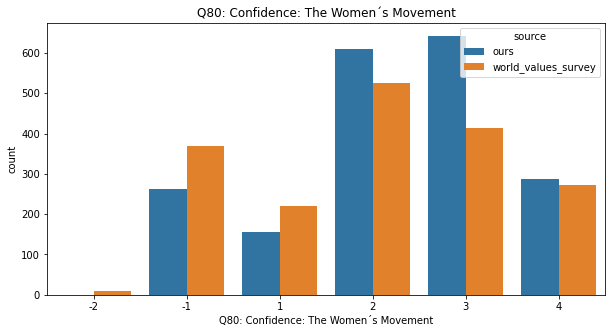

stat=7.159, p=0.000
Probably different distributions


In [293]:
col = 'Q80: Confidence: The Women´s Movement'
plot_cats(df, col)
ttest(df, col)

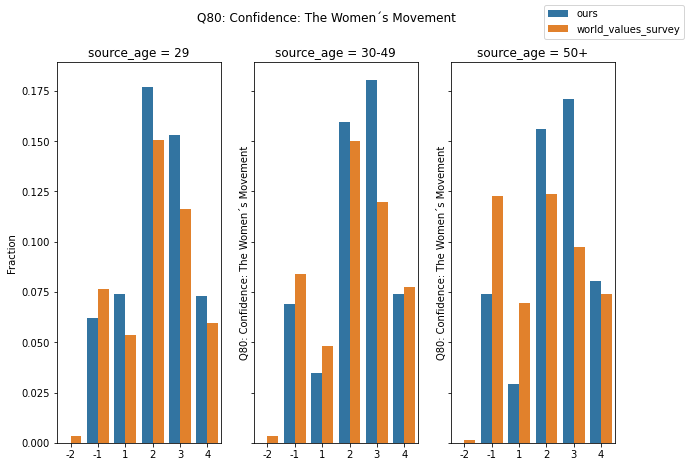

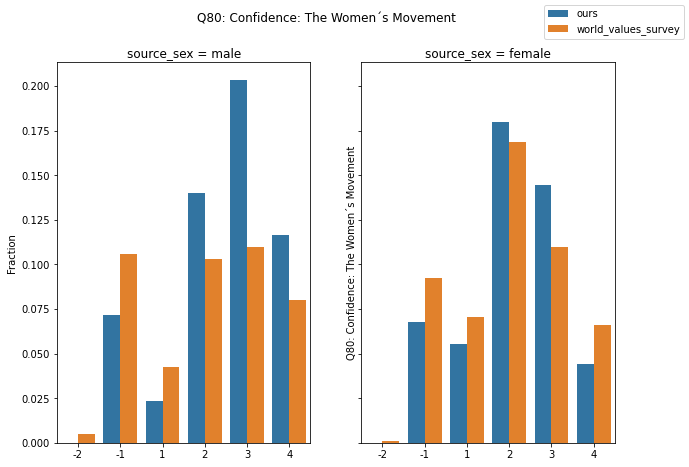

In [294]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [295]:
ttest(df[df.source_age=='29'], col)

stat=1.989, p=0.047
Probably different distributions


In [296]:
ttest(df[df.source_age=='30-49'], col)

stat=3.002, p=0.003
Probably different distributions


In [297]:
ttest(df[df.source_age=='50+'], col)

stat=6.716, p=0.000
Probably different distributions


In [298]:
ttest(df[df.source_sex=='male'], col)

stat=7.373, p=0.000
Probably different distributions


In [299]:
ttest(df[df.source_sex=='female'], col)


stat=2.479, p=0.013
Probably different distributions


## В Интернете больше верят в фальсификации 

* среди всех возрастных групп
* среди женщин и мужчин

Как часто в стране фальсифицируют выборы?

1 - очень часто

2 - скорее часто

3 - не очень часто

4 - совсем не часто

-1 - затрудняюсь ответить

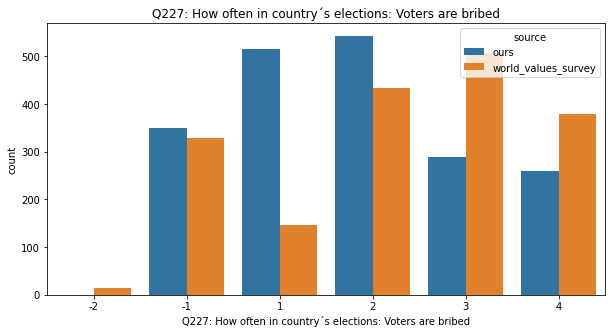

stat=-7.996, p=0.000
Probably different distributions


In [301]:
col = 'Q227: How often in country´s elections: Voters are bribed'
plot_cats(df, col)
ttest(df, col)

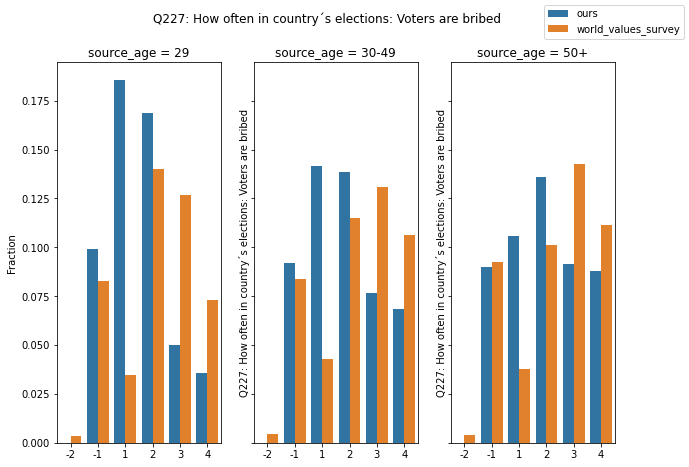

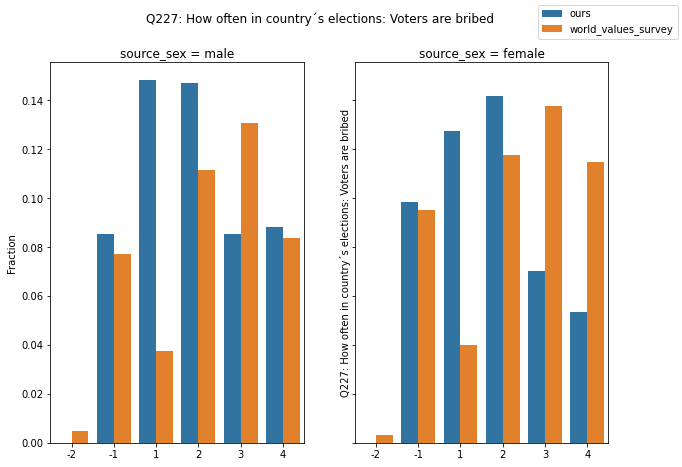

In [302]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [303]:
ttest(df[df.source_age=='29'], col)

stat=-5.884, p=0.000
Probably different distributions


In [304]:
ttest(df[df.source_age=='30-49'], col)

stat=-5.238, p=0.000
Probably different distributions


In [305]:
ttest(df[df.source_age=='50+'], col)

stat=-3.269, p=0.001
Probably different distributions


In [306]:
ttest(df[df.source_sex=='male'], col)

stat=-3.525, p=0.000
Probably different distributions


In [308]:
ttest(df[df.source_sex=='female'], col)

stat=-7.694, p=0.000
Probably different distributions


## Поляризация относительно иностранцев, люди больше за квоты И больще за пускать всех подряд
* среди всех возрастных групп
* среди женщин и мужчин

Имиграционная политика

1 - пускать любого, кто захочет

2 - пускать пока есть работа

3 - квоты

4 - никого не пускать

-1 - затрудняюсь

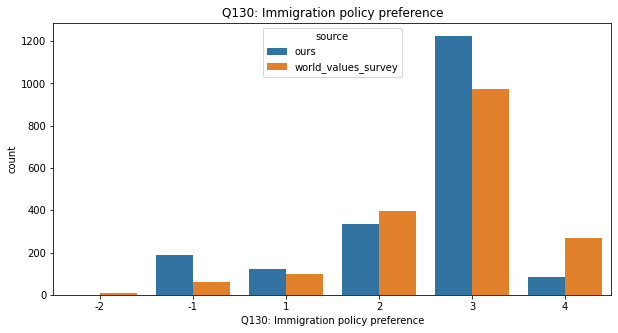

stat=-7.949, p=0.000
Probably different distributions


In [309]:

col = 'Q130: Immigration policy preference'
plot_cats(df, col)
ttest(df, col)

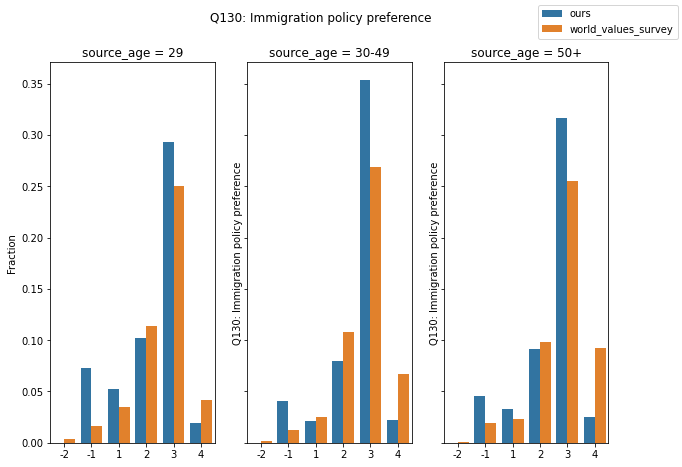

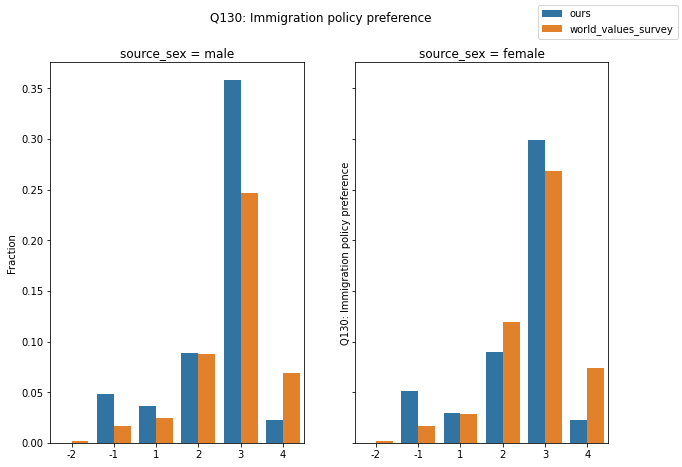

In [310]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [311]:
ttest(df[df.source_age=='29'], col)

stat=-4.513, p=0.000
Probably different distributions


In [312]:
ttest(df[df.source_age=='30-49'], col)

stat=-3.337, p=0.001
Probably different distributions


In [313]:
ttest(df[df.source_age=='50+'], col)

stat=-5.681, p=0.000
Probably different distributions


In [314]:
ttest(df[df.source_sex=='male'], col)

stat=-4.952, p=0.000
Probably different distributions


In [315]:
ttest(df[df.source_sex=='female'], col)

stat=-6.319, p=0.000
Probably different distributions


## В Интернете больше осуждают домашнее насилие

* но не среди старшего поколения
* и НЕ среди мужчин

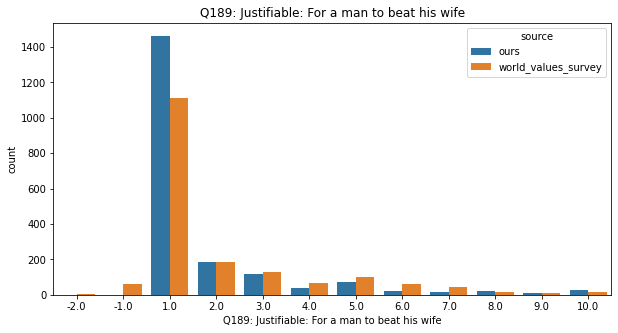

stat=-4.742, p=0.000
Probably different distributions


In [316]:

col = 'Q189: Justifiable: For a man to beat his wife'
plot_cats(df, col)
ttest(df, col)

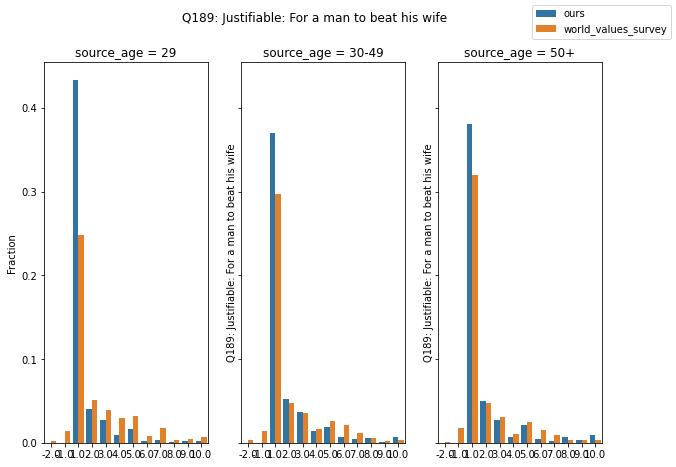

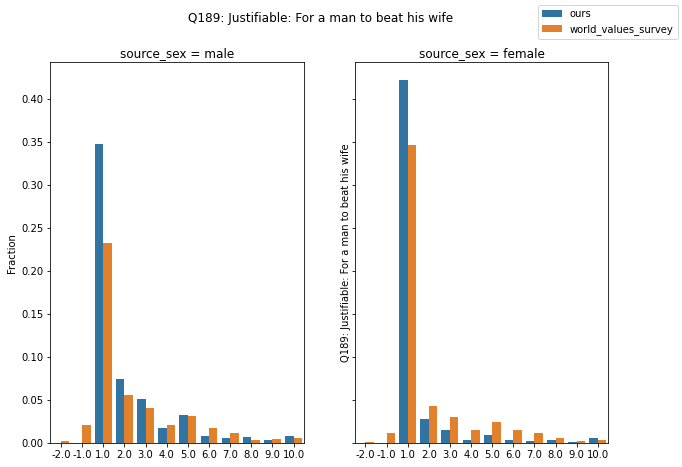

In [317]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [318]:
ttest(df[df.source_age=='29'], col)

stat=-6.244, p=0.000
Probably different distributions


In [319]:
ttest(df[df.source_age=='30-49'], col)

stat=-2.276, p=0.023
Probably different distributions


In [320]:
ttest(df[df.source_age=='50+'], col)

stat=-0.817, p=0.414
Probably the same distribution


In [321]:
ttest(df[df.source_sex=='male'], col)

stat=-1.619, p=0.106
Probably the same distribution


In [322]:
ttest(df[df.source_sex=='female'], col)



stat=-6.010, p=0.000
Probably different distributions


## Лояльнее к гомосексуализму

* среди молодёжи
* среди женщин и мужчин

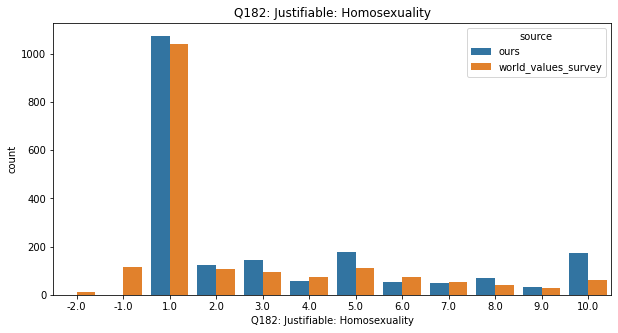

stat=8.527, p=0.000
Probably different distributions


In [323]:
col = 'Q182: Justifiable: Homosexuality'
plot_cats(df, col)
ttest(df, col)

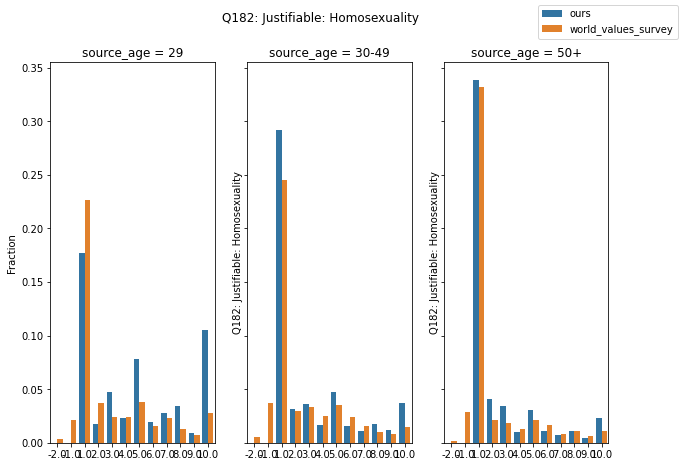

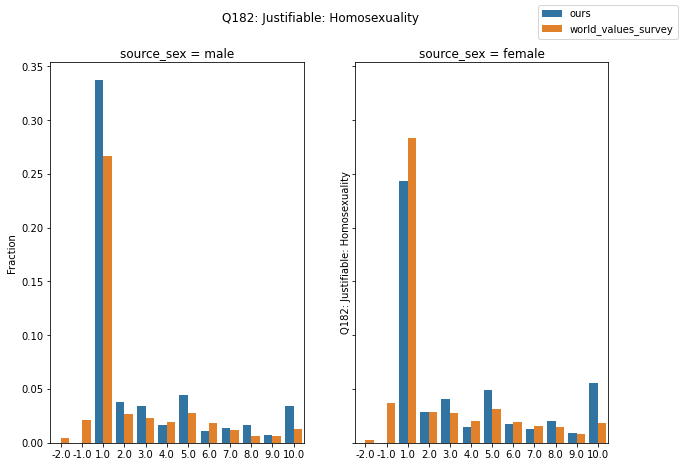

In [324]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [325]:
ttest(df[df.source_age=='29'], col)

stat=8.317, p=0.000
Probably different distributions


In [326]:
ttest(df[df.source_age=='30-49'], col)

stat=3.765, p=0.000
Probably different distributions


In [327]:
ttest(df[df.source_age=='50+'], col)

stat=2.826, p=0.005
Probably different distributions


In [328]:
ttest(df[df.source_sex=='male'], col)

stat=3.614, p=0.000
Probably different distributions


In [329]:
ttest(df[df.source_sex=='female'], col)

stat=8.454, p=0.000
Probably different distributions


## Чуть лояльнее относятся к проституткам

* среди всех возрастов
* среди женшин и мужчин

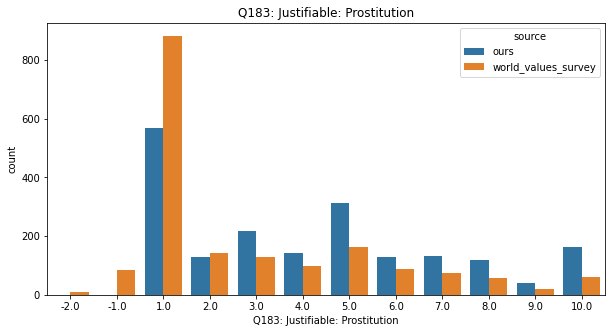

stat=16.252, p=0.000
Probably different distributions


In [330]:
col = 'Q183: Justifiable: Prostitution'
plot_cats(df, col)
ttest(df, col)

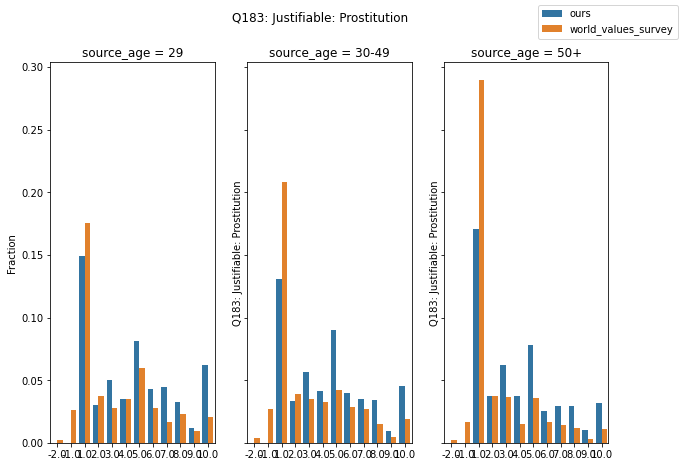

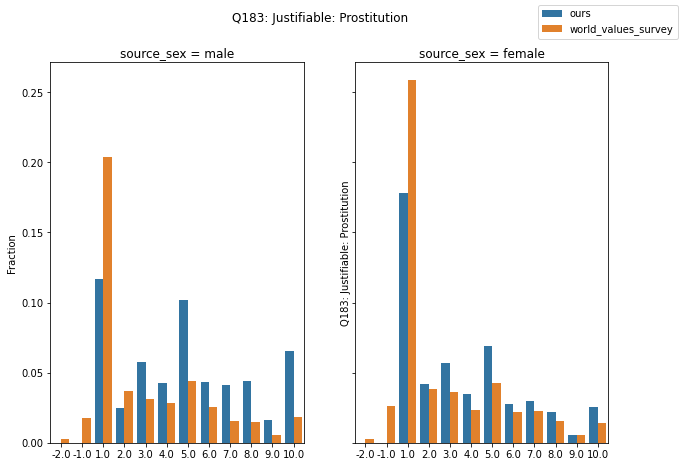

In [331]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [332]:
ttest(df[df.source_age=='29'], col)

stat=6.361, p=0.000
Probably different distributions


In [333]:
ttest(df[df.source_age=='30-49'], col)

stat=9.683, p=0.000
Probably different distributions


In [334]:
ttest(df[df.source_age=='50+'], col)

stat=11.688, p=0.000
Probably different distributions


In [335]:
ttest(df[df.source_sex=='male'], col)

stat=14.115, p=0.000
Probably different distributions


In [336]:
ttest(df[df.source_sex=='female'], col)


stat=8.497, p=0.000
Probably different distributions


## В интернете спокойнее относятся к абортам

* среди всех возрастных групп
* среди женщин и мужчин

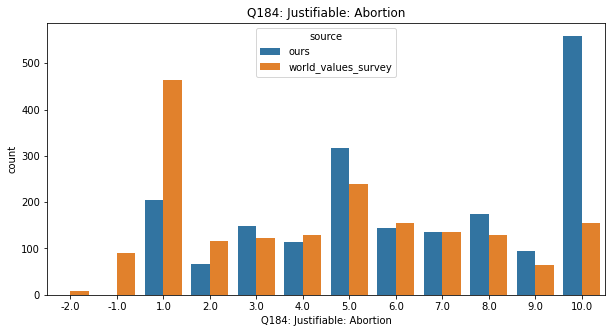

stat=20.539, p=0.000
Probably different distributions


In [337]:

col = 'Q184: Justifiable: Abortion'
plot_cats(df, col)
ttest(df, col)

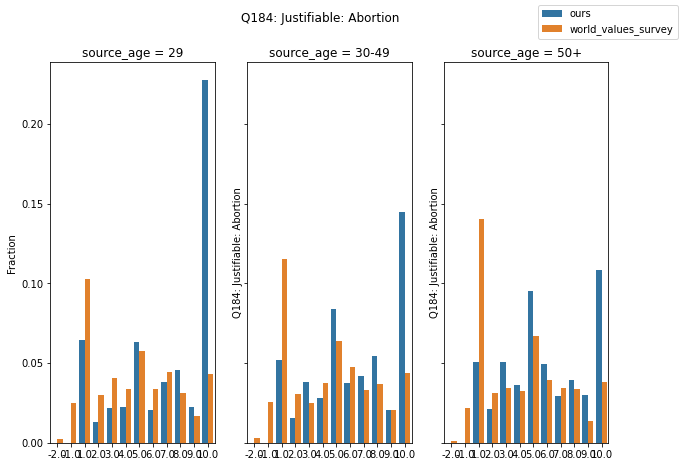

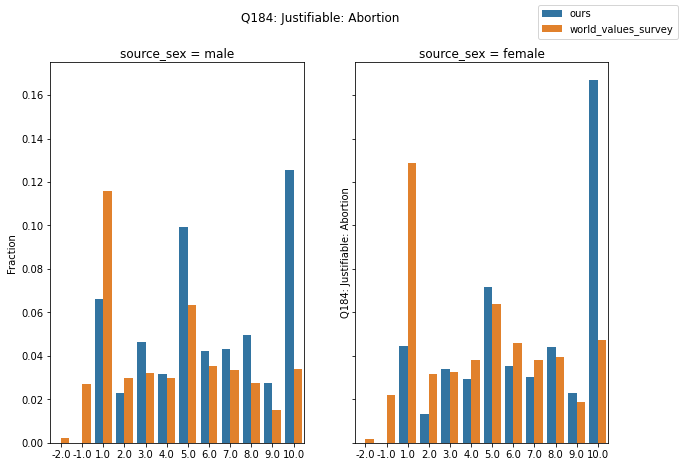

In [338]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [339]:
ttest(df[df.source_age=='29'], col)

stat=11.819, p=0.000
Probably different distributions


In [340]:
ttest(df[df.source_age=='30-49'], col)

stat=12.026, p=0.000
Probably different distributions


In [341]:
ttest(df[df.source_age=='50+'], col)

stat=11.886, p=0.000
Probably different distributions


In [342]:
ttest(df[df.source_sex=='male'], col)

stat=12.593, p=0.000
Probably different distributions


In [343]:
ttest(df[df.source_sex=='female'], col)


stat=16.740, p=0.000
Probably different distributions


## В интернете не хотят бить детей 

* среди всех групп населения, кроме молодёжи
* среди женщин и мужчин

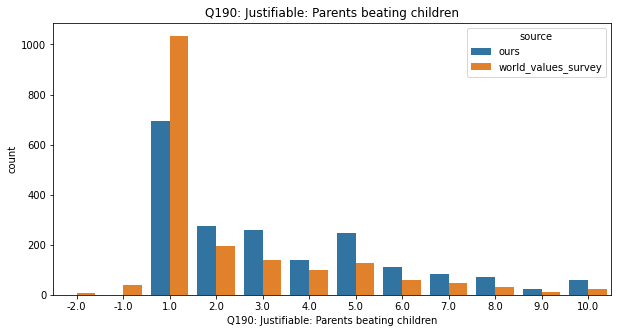

stat=13.579, p=0.000
Probably different distributions


In [344]:

col = 'Q190: Justifiable: Parents beating children'
plot_cats(df, col)
ttest(df, col)

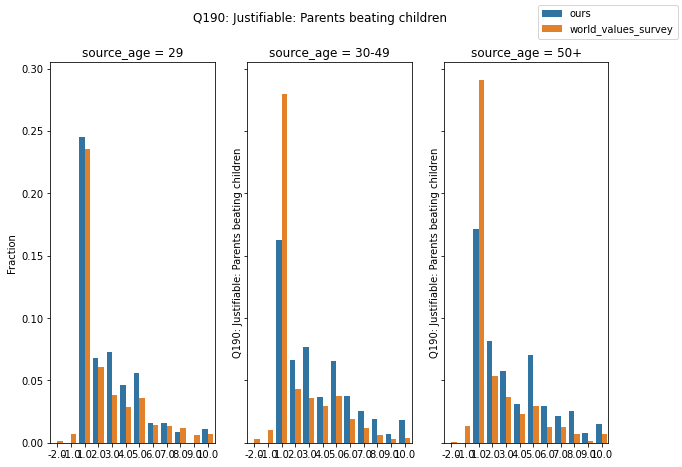

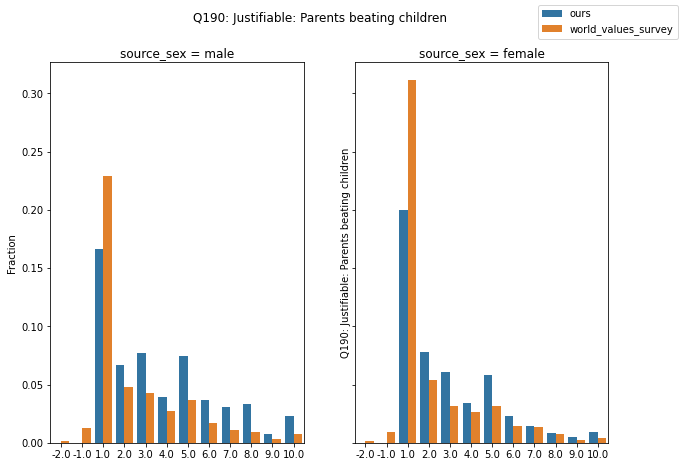

In [345]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [346]:
ttest(df[df.source_age=='29'], col)

stat=1.095, p=0.274
Probably the same distribution


In [347]:
ttest(df[df.source_age=='30-49'], col)

stat=10.225, p=0.000
Probably different distributions


In [348]:
ttest(df[df.source_age=='50+'], col)

stat=10.693, p=0.000
Probably different distributions


In [349]:
ttest(df[df.source_sex=='male'], col)

stat=10.286, p=0.000
Probably different distributions


In [350]:
ttest(df[df.source_sex=='female'], col)


stat=8.328, p=0.000
Probably different distributions


## В Интернете люди более сексуально раскрепощённые (PREFERENCE FALSIFICATION)

* среди всех возрастных групп
* среди женщин и мужчин

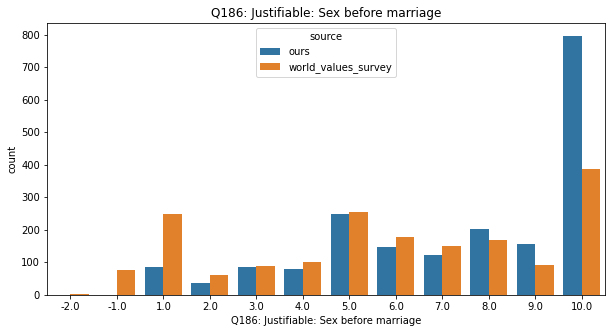

stat=17.574, p=0.000
Probably different distributions


In [352]:
col = 'Q186: Justifiable: Sex before marriage'
plot_cats(df, col)
ttest(df, col)

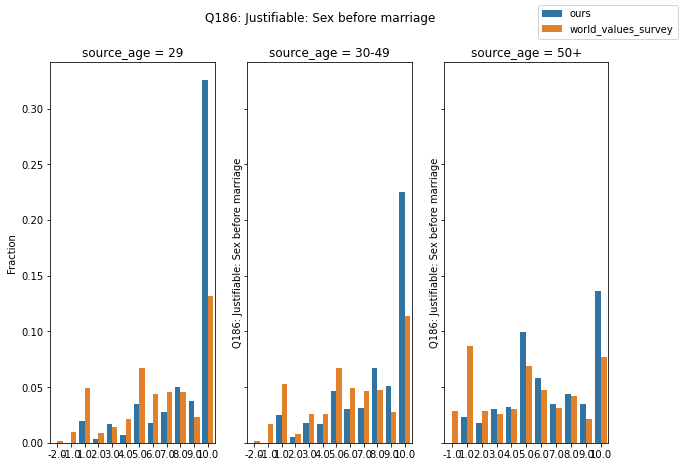

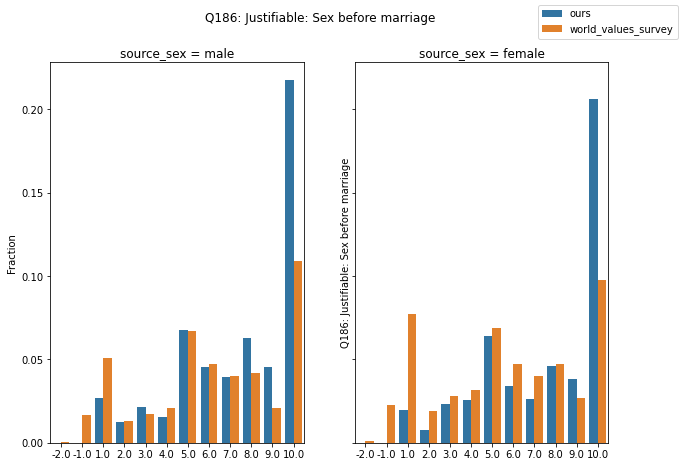

In [353]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [354]:
ttest(df[df.source_age=='29'], col)

stat=10.197, p=0.000
Probably different distributions


In [355]:
ttest(df[df.source_age=='30-49'], col)

stat=10.683, p=0.000
Probably different distributions


In [356]:
ttest(df[df.source_age=='50+'], col)

stat=10.239, p=0.000
Probably different distributions


In [357]:
ttest(df[df.source_sex=='male'], col)

stat=9.566, p=0.000
Probably different distributions


In [358]:
ttest(df[df.source_sex=='female'], col)



stat=14.744, p=0.000
Probably different distributions


## Лояльнее к суициду

* среди всех возрастынх групп
* среди женщин и мужчин

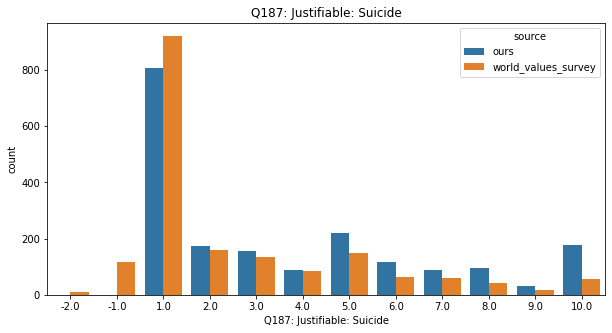

stat=13.610, p=0.000
Probably different distributions


In [359]:

col = 'Q187: Justifiable: Suicide'
plot_cats(df, col)
ttest(df, col)

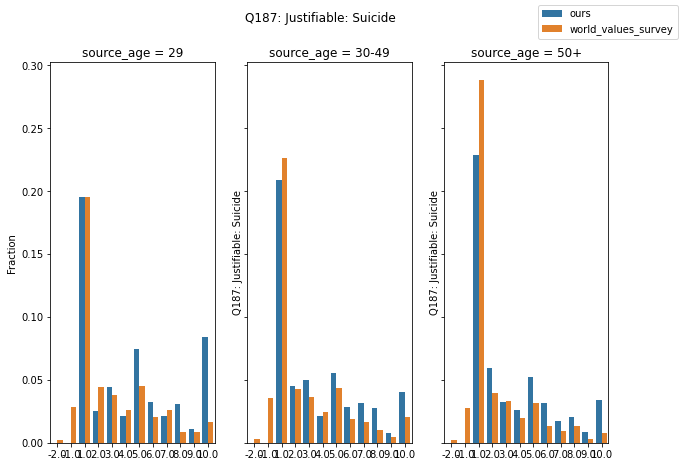

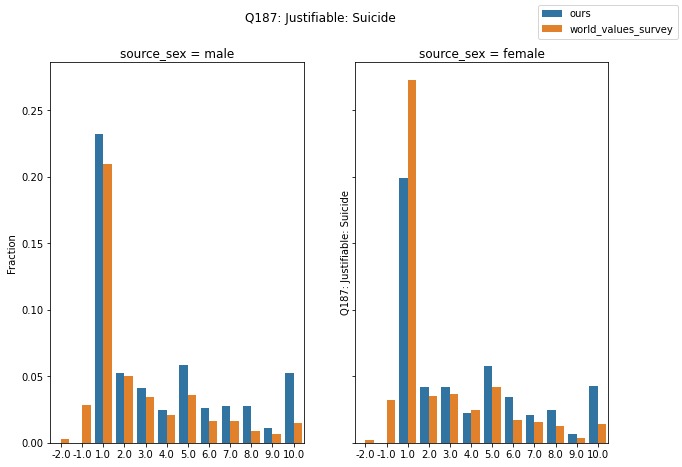

In [360]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [361]:
ttest(df[df.source_age=='29'], col)

stat=7.141, p=0.000
Probably different distributions


In [362]:
ttest(df[df.source_age=='30-49'], col)

stat=7.082, p=0.000
Probably different distributions


In [363]:
ttest(df[df.source_age=='50+'], col)

stat=9.264, p=0.000
Probably different distributions


In [364]:
ttest(df[df.source_sex=='male'], col)

stat=8.110, p=0.000
Probably different distributions


In [365]:
ttest(df[df.source_sex=='female'], col)


stat=10.942, p=0.000
Probably different distributions


## Более лояльны к эвтаназии

* среди всех возрастных групп
* среди женщин и мужчин

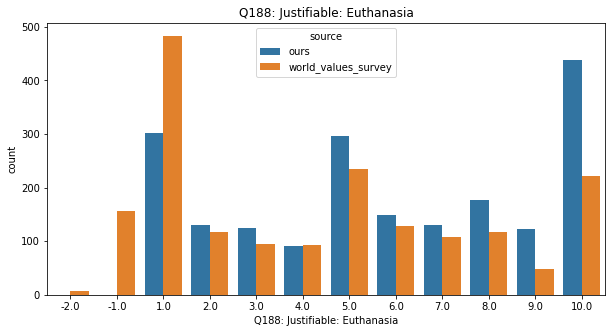

stat=15.740, p=0.000
Probably different distributions


In [366]:
col = 'Q188: Justifiable: Euthanasia'
plot_cats(df, col)
ttest(df, col)

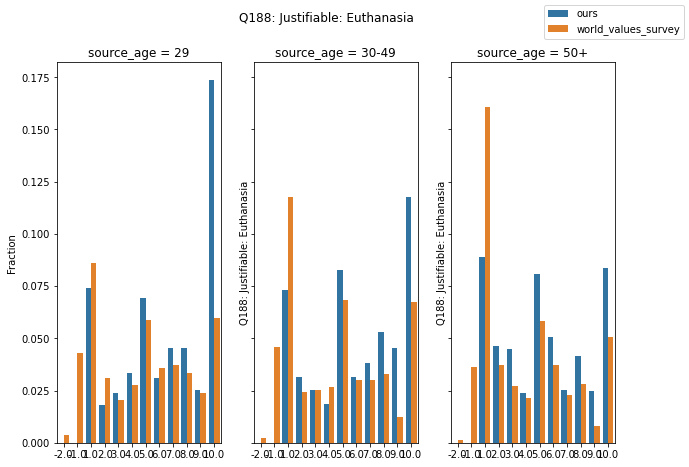

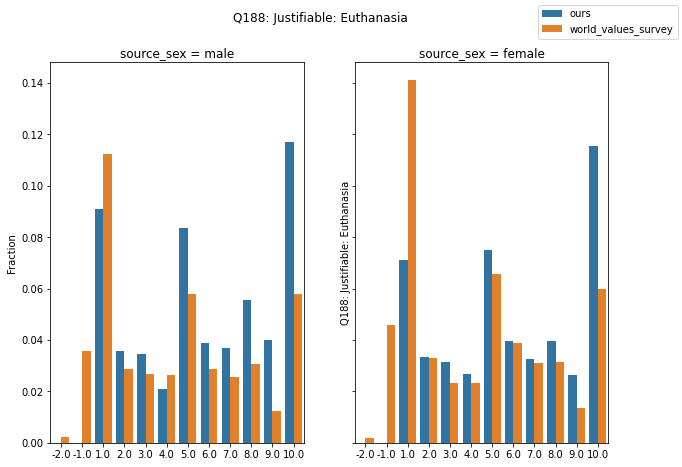

In [367]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [368]:
ttest(df[df.source_age=='29'], col)

stat=7.964, p=0.000
Probably different distributions


In [369]:
ttest(df[df.source_age=='30-49'], col)

stat=10.060, p=0.000
Probably different distributions


In [370]:
ttest(df[df.source_age=='50+'], col)

stat=9.120, p=0.000
Probably different distributions


In [371]:
ttest(df[df.source_sex=='male'], col)

stat=9.660, p=0.000
Probably different distributions


In [372]:
ttest(df[df.source_sex=='female'], col)


stat=12.383, p=0.000
Probably different distributions


stat=15.740, p=0.000
Probably different distributions


## Более сексуально раскрепощённые

* среди всех возрастных групп
* среди женщин и мужчин

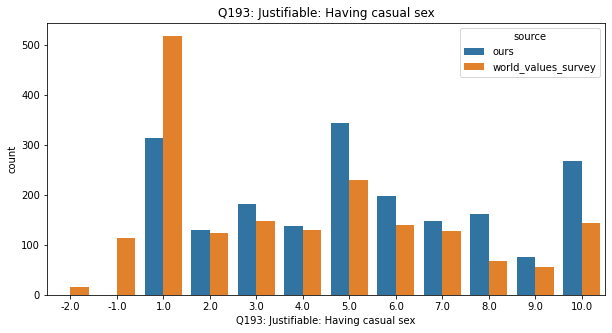

stat=14.134, p=0.000
Probably different distributions


In [373]:
col = 'Q193: Justifiable: Having casual sex'
plot_cats(df, col)
ttest(df, col)

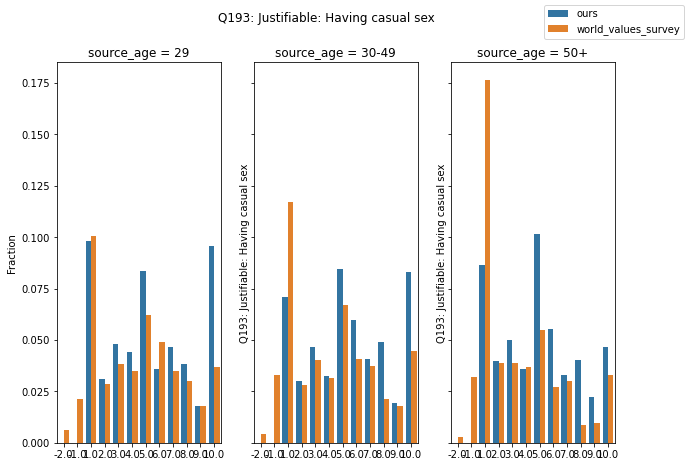

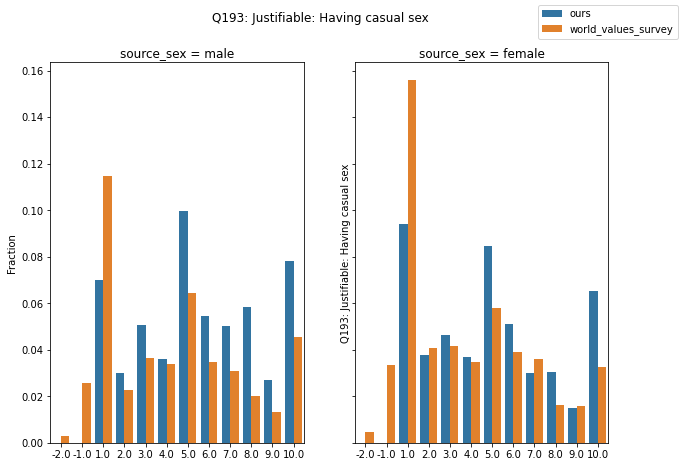

In [374]:
plot_cats_by_category_normalized(df, col, 'source_age')
plot_cats_by_category_normalized(df, col, 'source_sex')

In [375]:
ttest(df[df.source_age=='29'], col)

stat=4.467, p=0.000
Probably different distributions


In [376]:
ttest(df[df.source_age=='30-49'], col)

stat=8.447, p=0.000
Probably different distributions


In [377]:
ttest(df[df.source_age=='50+'], col)

stat=10.930, p=0.000
Probably different distributions


In [378]:
ttest(df[df.source_sex=='male'], col)

stat=9.448, p=0.000
Probably different distributions


In [379]:
ttest(df[df.source_sex=='female'], col)


stat=10.057, p=0.000
Probably different distributions


## Выводы

* статистически подтверждаются почти все гипотезы
* смущающие нас данные о полиции и правительстве НЕ подтвердились (хорошо), о неверии в фальсификации подтвердислиь (плохо) 
* можно объяснить, что через призму закручивания гаек люди верят, что ЕР честно получает голоса, оппозиция разуверилась в своих силах
* в некоторых случаях женщины толерантнее мужчин